# Stochastic Optimal Control

The goal of this notebook is to investigate whether the eigenfunction method can be used to solve stochastic optimal control problems. In particular, we wish to investigate how the eigenfunction approximation performs for increasing $k$ and compare with SOTA.

## Problem Setting

We consider a controlled stochastic process
$$dX_t^u = (b(X_t^u,t) + \sigma(t) u(X_t^u,t)) dt + \sqrt{\lambda} \sigma(t) dW_t$$
where $u$ is the control. The goal is to minimize the cost function
$$\mathbb{E}\left[\int_0^T \left(\frac{1}{2}\|u(X_t,t)\|^2 + f(X_t^u,t)\right)dt + g(X_T^u)\right],$$
where $f$ is some running cost and $g$ is the terminal cost. To do this, introduce the cost functional
$$ J(u;x,t) = \mathbb{E} \left[\int_t^T \left(\frac{1}{2}\|u(X_t,t)\|^2 + f(X_t^u,t)\right)dt + g(X_T^u){\Large|} X_t^u = x\right]$$
which gives the expected cost when using control $u$, starting from position $x$ at time $t$. The <i>value function</i> is then defined through
$$V(x,t) = \inf_{u} J(u;x,t)$$
It can be shown that the optimal control is related to the value function as
$$u^*(x,t) = -\sigma(t)^T \nabla V(x,t).$$

The idea of our method is to use the following path integral representation of the value function:
$$V(x,t) = -\lambda \log \mathbb{E}\left[\exp\left(-\lambda^{-1} \int_{t}^T f(X_s,s) ds - \lambda^{-1} g(X_T)\right) {\Large|} X_t = x\right]$$

By the Feynman-Kac theorem, the above expectation satisfies the PDE
$$\frac{\partial v}{\partial t} - \mathcal{L} v - \lambda^{-1} f(x,t)v = 0, \qquad v(T,x) = \exp\left(-\lambda^{-1}g(x)\right)$$
where $\mathcal{L}$ is the negative of the infinitesimal generator of the diffusion,
$$\mathcal{L} = - \frac{\lambda}{2} (\sigma \otimes \sigma)\nabla^2 - b^T\nabla.$$
In particular, the setting we are interested in is where $b(x,t) = -\nabla E(x)$ for some energy $E$, and $\sigma(t) = \sigma_0 I$. In this case the PDE can be rewritten as
$$\frac{\partial v}{\partial t} + \mathcal{L}v + \lambda^{-1} f(x,t) v = 0, \qquad v(0,x) = \exp\left(-\lambda^{-1}g(x)\right)$$
where $\mathcal{L}$ is the negative infinitesimal generator of Langevin dynamics,
$$\mathcal{L}v = -\frac{\lambda}{2}\sigma_0^2 \Delta v + <\nabla E, \nabla v>.$$
Now the idea is that we can consider the eigenfunctions of the operator $\mathcal{K}$ defined through
$$\mathcal{K}v = \mathcal{L}v + \lambda^{-1} f(x,t) v.$$
This operator is self-adjoint w.r.t to the $L^2$ metric weighted with $\mu(x) \propto \exp(-E(x))$. Denoting the eigensystem as $(\phi_i, \lambda_i)$, then we can solve the PDE as
$$v(x,t) = \sum_{k=0}^\infty <e^{-\lambda^{-1}g}, \phi_k>_\mu \phi_k e^{-\lambda_k t}$$
and retrieve the optimal control as 
$$V(x,t) = -\lambda \log v(x,t), \qquad u^*(x,t) = \sigma_0\lambda \frac{\nabla v(x,t)}{v(x,t)}$$
The essential question is now the following: is this solution good if we truncate this solution to only use a limited number of eigenfunctions? This is what we set out to answer in this notebook.




## Imports

In [1]:
import sys
import os

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# Get the parent directory (one level above)
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)

import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
import torch
import math

from tqdm import tqdm

from src.energy.quadratic import QuadraticEnergy

## LQR

### Setup

We consider first a setting where we know the eigenfunctions exactly. This is the case for the Linear-Quadratic Regulator, which has
$$E(x) = -\frac{1}{2}x^T A x,\quad b(x) = Ax,\quad f(x,t) = x^T P x,\quad g(x) = x^T Q x.$$
That is: the energy, running and terminal cost are all quadratic. In this case, one can solve the system exactly using the Ricatti equation to obtain the optimal control
$$u_t^*(x) = -2\sigma_0 F_t x$$
where $F_t$ is the solution to the Ricatti equation
$$\frac{dF_t}{dt} + A^T F_t + F_tA - 2F_t \sigma_0^2 F_t + P = 0, \qquad F_T = Q$$

In [2]:
# The following code is copy-pasted from SOC-Matching GitHub
def solution_Ricatti(R_inverse, A, P, Q, t):
    FT = Q
    Ft = [FT]
    for t0, t1 in zip(t[:-1], t[1:]):
        dt = t1 - t0
        FT = FT - dt * (
            -torch.matmul(torch.transpose(A, 0, 1), FT)
            - torch.matmul(FT, A)
            + 2 * torch.matmul(torch.matmul(FT, R_inverse), FT)
            - P
        )
        Ft.append(FT)
    Ft.reverse()
    return torch.stack(Ft)

def optimal_control_LQ(sigma, A, P, Q, t):
    R_inverse = torch.matmul(sigma, torch.transpose(sigma, 0, 1))
    Ft = solution_Ricatti(R_inverse, A, P, Q, t)
    ut = -2 * torch.einsum("ij,bjk->bik", torch.transpose(sigma, 0, 1), Ft)
    return ut

The metric that is used in the SOCM paper is the following:
$$\mathbb{E}_{t, \mathbb{P}^{u^*}} \left[\|u^*(X_t,u^*) - u(X_t^{u^*})\|^2\right]$$
Hence we need to generate some trajectories from the optimal control.

In [3]:
def sde_step(x, dt, u, A, sigma, lmbda):
    """
    Simulate one step of the dynamical system, using the control u
    Args:
        x (tensor)[N,d]: initial points
        dt (float): timestep
        u (tensor)[N,d]: control
        A (tensor)[d,d]: drift matrix
        sigma (tensor)[d,d]: noise matrix
        lmbda (float): noise scale
    Returns:
        x_new (tensor)[N,d]: new points
    """
    dw = torch.randn(x.shape)
    x_new = x + (x@A + u @ sigma) * dt + np.sqrt(lmbda * dt) * dw @ sigma
    return x_new

def optimal_control_trajectory(x, T, K, A, P, Q, sigma, lmbda, seed = 0):
    """
    Simulate the optimal control trajectory starting from x in [0,T] using K discretization steps.
    Args:
        x (tensor)[N,d]: initial points
        T (float): final time
        K (int): timesteps
        A (tensor)[d,d]: drift matrix
        P (tensor)[d,d]: running cost matrix
        Q (tensor)[d,d]: terminal cost matrix
        sigma (tensor)[d,d]: noise matrix
        lmbda (float): noise scale
        seed (int): random seed
    Returns:
        trajectory (tensor)[K+1,N,d]: trajectory under optimal control
    """
    torch.manual_seed(seed)

    dt = T / (K + 1)
    t = torch.linspace(0,T, 10*K + 1)
    ut = optimal_control_LQ(sigma, A, P, Q, t)[::10]

    trajectory = torch.zeros((K+1,) + x.shape)
    control = torch.zeros((K+1,) + x.shape)
    trajectory[0] = x
    
    u_opt = x @ ut[0] 
    control[0] = u_opt

    for i in tqdm(range(1,K+1)):
        x = sde_step(x, dt, u_opt, A, sigma, lmbda)
        u_opt = x @ ut[i]
        trajectory[i] = x
        control[i] = u_opt
    
    return trajectory, control

def no_control_trajectory(x, T, K, A, sigma, lmbda, seed = 0):
    """
    Simulate the optimal control trajectory starting from x in [0,T] using K discretization steps.
    Args:
        x (tensor)[N,d]: initial points
        T (float): final time
        K (int): timesteps
        A (tensor)[d,d]: drift matrix
        sigma (tensor)[d,d]: noise matrix
        lmbda (float): noise scale
        seed (int): random seed
    Returns:
        trajectory (tensor)[K+1,N,d]: trajectory under optimal control
    """
    torch.manual_seed(seed)
    
    dt = T / (K + 1)
    t = torch.linspace(0,T, 10*K + 1)

    trajectory = torch.zeros((K+1,) + x.shape)
    trajectory[0] = x
    control = torch.zeros_like(x)

    for i in tqdm(range(1,K+1)):
        x = sde_step(x, dt, control, A, sigma, lmbda)
        trajectory[i] = x
    
    return trajectory

### 1D demo

The following illustrates the optimal control for $d = 1$

In [4]:
dim = 1
A = torch.eye(dim) * 0.2 
P = torch.eye(dim) * 0.2
Q = torch.eye(dim) * 0.1
sigma = torch.eye(dim)
lmbda = 1.0

K = 1000
T = 5
x = torch.randn((10000,dim)) + 5
t = torch.linspace(0,1,K+1)

trajectory, control = optimal_control_trajectory(x, T, K, A, P, Q, sigma, lmbda, seed = 0)
free_trajectory = no_control_trajectory(x, T, K, A, sigma, lmbda, seed = 0)

100%|██████████| 1000/1000 [00:00<00:00, 7647.73it/s]


Text(0.5, 1.0, 'Optimal control for quadratic OU problem with positive drift')

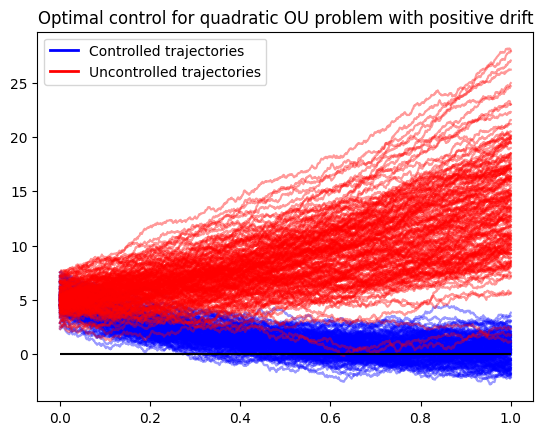

In [5]:
from matplotlib.lines import Line2D

i = 150
plt.plot(t, trajectory[:,:i,0], color = 'blue', alpha = .4)
#plt.plot(t, control[:,i,0], color = 'blue', ls = '--')

#plt.twinx()
plt.plot(t, free_trajectory[:,:i,0], color = 'red', alpha = .4, label = 'uncontrolled')
plt.hlines(0,t[0],t[-1], color = 'black')

custom_lines = [
    Line2D([0], [0], color='b', lw=2, label='Controlled trajectories'),
    Line2D([0], [0], color='r', lw=2, label='Uncontrolled trajectories')
]

plt.legend(handles=custom_lines)
plt.title('Optimal control for quadratic OU problem with positive drift')

### Eigenfunctions

Now, let us construct the eigenfunctions for the operator $\mathcal{K}$. In the LQR case with $\sigma_0 = 1$,
$$\mathcal{K}v = -\frac{\lambda}{2} \Delta v - <Ax, \nabla v> + \lambda^{-1} x^T P x\ v.$$
We can rewrite this as 
$$\mathcal{K}v = \frac{\lambda}{2} \left(-\Delta v -  \frac{2}{\lambda} < Ax, \nabla v> + \frac{2}{\lambda^2} x^T P x v\right)$$
Now suppose that $D^*$ is the matrix such that
\begin{equation}
-(D^*)^T D^* + \frac{2}{\lambda}AD^* +\frac{2}{\lambda^2} P = 0.
\end{equation}
Then it holds that for $v(x) = w(x) \exp\left(-\frac{1}{2}x^T D^* x\right)$,
$$\mathcal{K}v = \frac{\lambda}{2} \left(-\Delta w + <\left(-\frac{2}{\lambda}A + 2D^*\right)x, \nabla w> + \text{Tr}(D^*)w\right)\exp\left(-\frac{1}{2}x^T D^* x\right)$$


We can compute the functions $w_\alpha$ which are eigenfunctions for the term in brackets (with eigenvalue $\tilde\lambda_\alpha$), and then the eigensystem for $\mathcal{K}$ is given by
$$\phi_\alpha(x) = w_\alpha(x) \exp\left(-\frac{1}{2}x^T D^* x\right), \qquad \lambda_\alpha = \frac{\lambda}{2}\left(\tilde\lambda_\alpha + \text{Tr}(D^*)\right)$$

We can solve equation (1) exactly when $A = aI$. Indeed, suppose $P = U\Lambda U^T$. Then the ansatz $D^* = U\Kappa U^T$ gives
$$-\Kappa^2 + \frac{2a}{\lambda} \Kappa + \frac{2}{\lambda^2}\Lambda = 0$$
which has solutions given by
$$\kappa_i = \frac{a}{\lambda}\left(1 \pm \sqrt{1+\frac{\lambda_i}{a^2}}\right)$$
Depending on the sign of $a$, either the positive or negative solution must be taken to have positive $\kappa$ (Note that for the system to have well-defined eigenfunctions, we must have $-\frac{2}{\lambda} A + 2D^*$ be positive definite).

In [413]:
torch.set_default_dtype(torch.float64)

In [414]:
def compute_D(A,P,lmbda):
    assert torch.allclose(A, torch.eye(A.shape[0])*A[0,0])
    Lambda, U = torch.linalg.eigh(P)

    a = torch.diag(A)
    sign = torch.where(a > 0, 1.0, -1.0)
    print(sign)
    kappa = torch.diag(A) / lmbda * (1 + sign * torch.sqrt(1 + 2 / a**2 * Lambda))

    return U @ torch.diag(kappa) @ U.T

# sanity check

dim = 3
lmbda = 3.0
x = torch.randn((dim,dim))
P = x@x.T
A = - torch.eye(dim)*10

D = compute_D(A, P, lmbda)
print(torch.allclose(D.T @ D - 2 / lmbda * A @ D, 2/ lmbda**2 * P))

A = torch.eye(dim)*0.3
D = compute_D(A, P, lmbda)
print(torch.allclose(D.T @ D - 2 / lmbda * A @ D, 2/ lmbda**2 * P))

tensor([-1., -1., -1.])
True
tensor([1., 1., 1.])
True


In [428]:
dim = 5
A = torch.eye(dim) * 1
P = torch.eye(dim) * 0.2
Q = torch.eye(dim) * 0.1
sigma = torch.eye(dim)
lmbda = 1

D = compute_D(A, P, lmbda)
D

tensor([1., 1., 1., 1., 1.])


tensor([[2.1832, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.1832, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.1832, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 2.1832, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.1832]])

In [429]:
-2/lmbda * A + 2*D

tensor([[2.3664, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.3664, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.3664, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 2.3664, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.3664]])

In [430]:
energy = QuadraticEnergy(-2/lmbda * A + 2*D)

def exact_eigfunctions(x, m):
    """
    Evaluate first m exact eigenfunctions of K at points x
    Args:
        x (tensor)[n,d]: evaluation points
        m (int): number of eigenfunctions to compute
    Returns:
        fx (tensor)[n,m]: first m eigenfunction evaluations
    """
    fx = energy.exact_eigfunctions(x, m) * torch.exp(- 1/2 * torch.einsum('ij, ij -> i',x @ D, x))[:,None]
    return fx

def log_exact_eigfunctions(x, m):
    """
    Evaluate log of first m exact eigenfunctions of K at points x
    Args:
        x (tensor)[n,d]: evaluation points
        m (int): number of eigenfunctions to compute
    Returns:
        fx (tensor)[n,m]: first m eigenfunction evaluations
    """
    fx = torch.log(energy.exact_eigfunctions(x, m)) - 1/2 * torch.einsum('ij, ij -> i',x @ D, x)[:,None]
    return fx

def exact_eigvals(k):
    """
    Compute m smallest exact eigenvalues of K 
    Args:
        m (Int)
    Returns:
        eigvals (tensor)
    """
    eigvals = lmbda/2 * (energy.exact_eigvals(k) + torch.einsum('ii -> i', D))
    return eigvals

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x1 and 5x5)

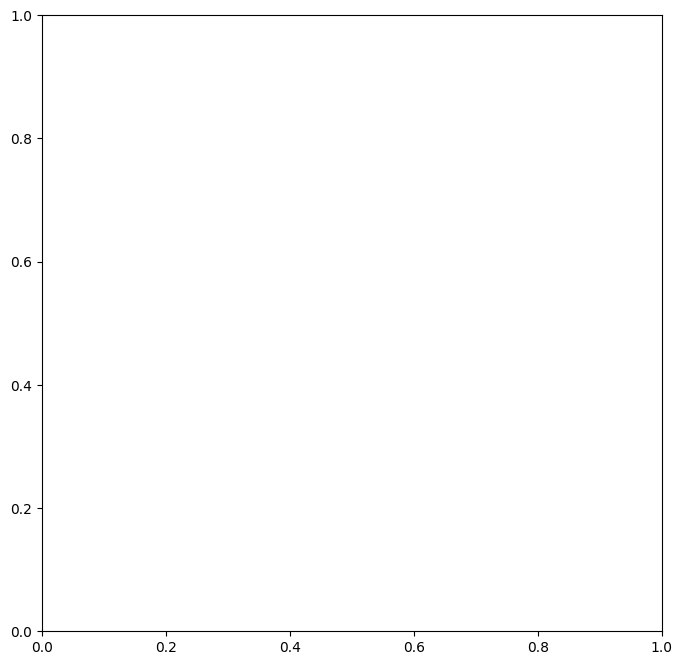

In [431]:
x = torch.linspace(-5, 5,1000)[:,None]

k = 10
fig, ax = plt.subplots(figsize=(8,8))
blue_colors = [(0, 0, (i / k)) for i in range(1, k + 1)]  # RGB: (Red, Green, Blue)

fx = exact_eigfunctions(x,k)
eigvals = exact_eigvals(k)
for i in range(k):
    ax.plot(x, fx[:,i], color = blue_colors[i], label = f'k = {i+1}, lambda = {eigvals[i]:.3f}')

ax.set_title('Exact eigenfunctions of K')
plt.legend()

Equipped with these exact eigenfunctions, we can now start solving the PDE. To do this, we need to compute inner products w.r.t. the measure defined through
$$<f,g> = \int f(x)g(x) \exp(-E(x))dx$$
If $\exp(-E)$ is integrable, we can do this by sampling from the equilibrium measure. In our case this does not hold, since $E(x) = - \frac{1}{2}x^T A x$ for some spd $A$. We can try to do something like
$$<f,g> = \mathbb{E}_x \left[f(x)g(x) e^{x^T A x}\right]$$
for $x \sim \mathcal{N}(0,A^{-1})$. Clearly, we need some strong conditions on our functions $f$ and $g$ in order for expectations to be finite. However, in the setting we are considering this is the case.

In [432]:
equilibrium_energy = QuadraticEnergy(A)
samples = equilibrium_energy.exact_sample((100000,))

In [433]:
fsamples = exact_eigfunctions(samples, 10)
fsamples.shape

torch.Size([100000, 10])

In [434]:
quadratic_form = torch.exp(torch.einsum('ij, ij -> i',samples @ A, samples))

norms = ((fsamples**2 * quadratic_form[:,None]).mean(dim=0)).sqrt()
fsamples = fsamples / norms

inner_prods = (fsamples[:,None,:] * fsamples[:,:,None] * quadratic_form[:,None,None]).mean(dim=0)

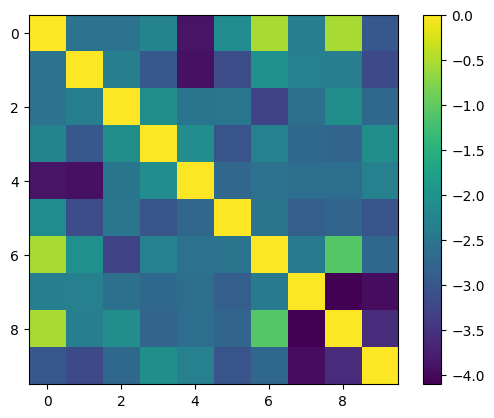

In [435]:
plt.imshow(inner_prods.abs().log10())
plt.colorbar()

In [436]:
fsamples = equilibrium_energy.exact_eigfunctions(samples, 10)

true_inner_prods = (fsamples[:,None,:] * fsamples[:,:,None]).mean(dim=0)

In [442]:
(inner_prods-torch.eye(inner_prods.shape[0]))**2

tensor([[ 2.2204e-16, -2.8264e-03,  2.8815e-03,  5.4627e-03,  1.3117e-04,
         -7.7343e-03, -2.8680e-01, -4.4925e-03, -2.8791e-01,  1.0730e-03],
        [-2.8264e-03, -3.3307e-16, -4.4902e-03,  1.0712e-03,  1.2148e-04,
          7.4359e-04, -9.1771e-03,  4.9069e-03,  4.4433e-03,  6.4678e-04],
        [ 2.8815e-03, -4.4902e-03, -1.1102e-16, -8.4566e-03,  3.1434e-03,
          3.2337e-03,  5.4268e-04,  2.5283e-03, -8.3200e-03, -1.8926e-03],
        [ 5.4627e-03,  1.0712e-03, -8.4566e-03, -1.1102e-16, -8.0083e-03,
         -9.0037e-04, -4.8267e-03, -1.8904e-03, -1.7022e-03, -8.4245e-03],
        [ 1.3117e-04,  1.2148e-04,  3.1434e-03, -8.0083e-03,  2.2204e-16,
          1.7914e-03,  2.6528e-03, -2.3605e-03, -2.4154e-03, -4.8877e-03],
        [-7.7343e-03,  7.4359e-04,  3.2337e-03, -9.0037e-04,  1.7914e-03,
         -1.1102e-16, -2.9933e-03,  1.3640e-03, -1.7127e-03, -9.1948e-04],
        [-2.8680e-01, -9.1771e-03,  5.4268e-04, -4.8267e-03,  2.6528e-03,
         -2.9933e-03,  2.2204e-1

Text(0.5, 1.0, 'Old operator inner products')

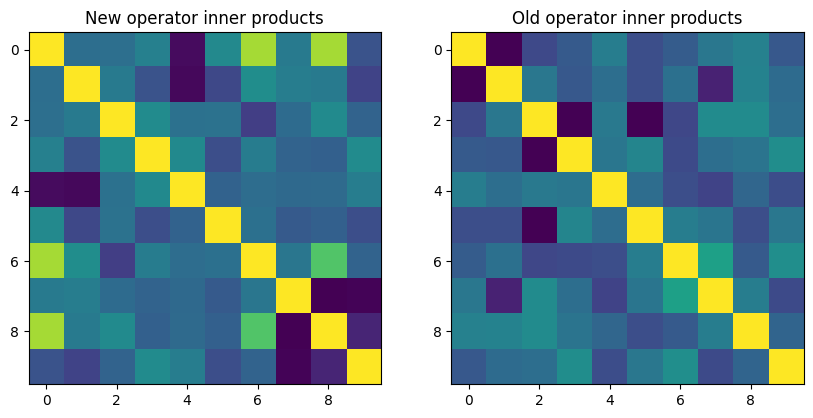

In [437]:
fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(torch.clip(inner_prods.abs().log10(),-4,0))
ax[0].set_title('New operator inner products')
ax[1].imshow(torch.clip(true_inner_prods.abs().log10(),-4,0))
ax[1].set_title('Old operator inner products')